## Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

In [26]:
from sklearn.model_selection import cross_val_score
score = lambda estimator, X, y : cross_val_score(estimator, X, y, cv = 10).mean()
ranf = lambda f : int(f**0.5)

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

(1797, 64)

## Задание

__1.__ Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score.

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
score(dtc, X, y)

0.8236247612849269

__2.__ Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [20]:
??BaggingClassifier

In [18]:
from sklearn.ensemble import BaggingClassifier
bc_dtc = BaggingClassifier(dtc, n_estimators=100, n_jobs=-1)
bc_dtc.fit(X, y)
score(bc_dtc, X, y)

0.92373909015727862

__3.__ Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех $d$ признаках, а на $\sqrt{d}$ случайных признаков.

Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [22]:
bcf_dtc = BaggingClassifier(dtc, n_estimators=100, max_features=ranf(X.shape[1]), n_jobs=-1)
bcf_dtc.fit(X, y)
score(bcf_dtc, X, y)

0.93212455242135983

__4.__ Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Попробуйте выбирать опять же $\sqrt{d}$ признаков. 

In [23]:
dtcf = DecisionTreeClassifier(max_features=ranf(X.shape[1]))
bc_dtcf = BaggingClassifier(dtcf, n_estimators=100, n_jobs=-1)
bc_dtcf.fit(X, y)
score(bc_dtcf, X, y)

0.9560832888858295

__5.__ Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности постройте графики зависимости качества от значений параметров.

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X, y)
score(rfc, X, y)

0.94994642254393435

In [63]:
#from sklearn.model_selection import GridSearchCV
def scores_param(params):
    scores = []
    for k, v in params.items():
        for i in v:
            if k != 'n_estimators':
                d = {'n_estimators' : 100, k : i, 'n_jobs': - 1}
                #rf = RandomForestClassifier(n_estimators = 100, k = i, n_jobs=- 1)
            else:
                d = {'n_estimators' : i, 'n_jobs' : - 1}
                #rf = RandomForestClassifier(n_estimators = i, n_jobs=- 1)
            rf = RandomForestClassifier(**d)
            rf.fit(X, y)
            scores.append(score(rf, X, y))
    return scores

n_trees = {'n_estimators' : [5, 10, 15, 30, 50 ,75, 100, 150, 200, 400, 600, 750]}
n_features = {'max_features' : [1, 2, 5, 8, 10, 15, 20, 30, 40, 50, 60]}
n_depth = {'max_depth' : [2, 3, 4, 5, 6, 8, 10, 13, 16, 20, 30, 50]}

scores_trees = scores_param(n_trees)
scores_features = scores_param(n_features)
scores_depth = scores_param(n_depth)

In [66]:

scores_trees = scores_param(n_trees)

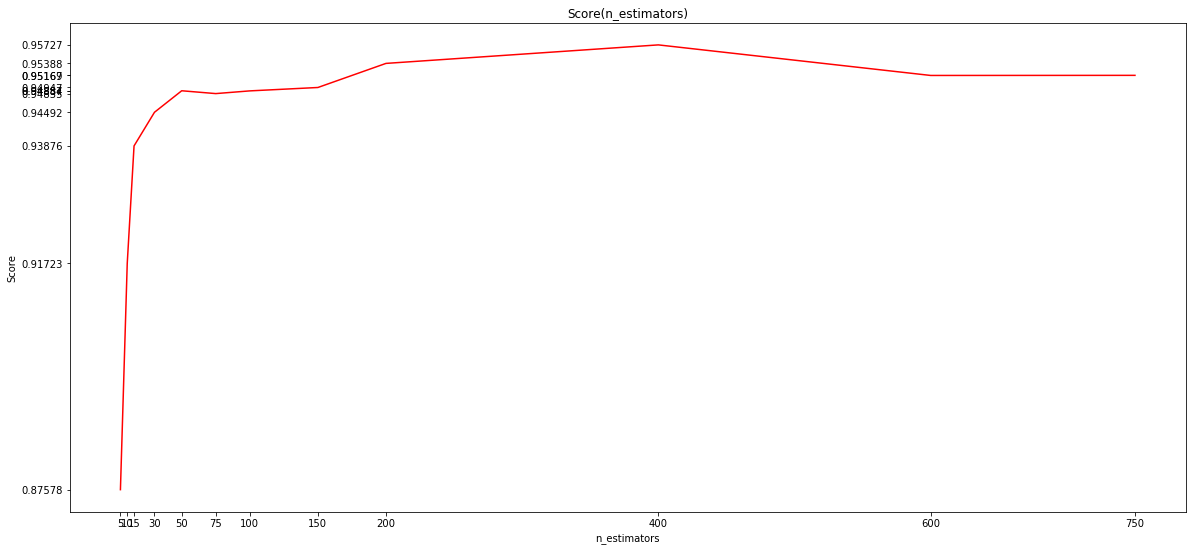

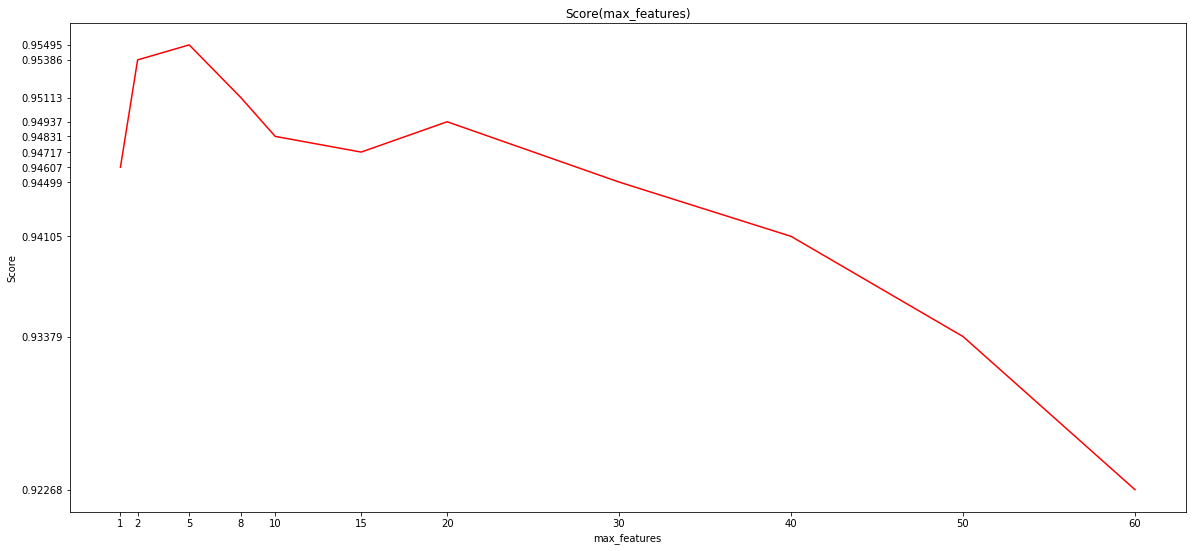

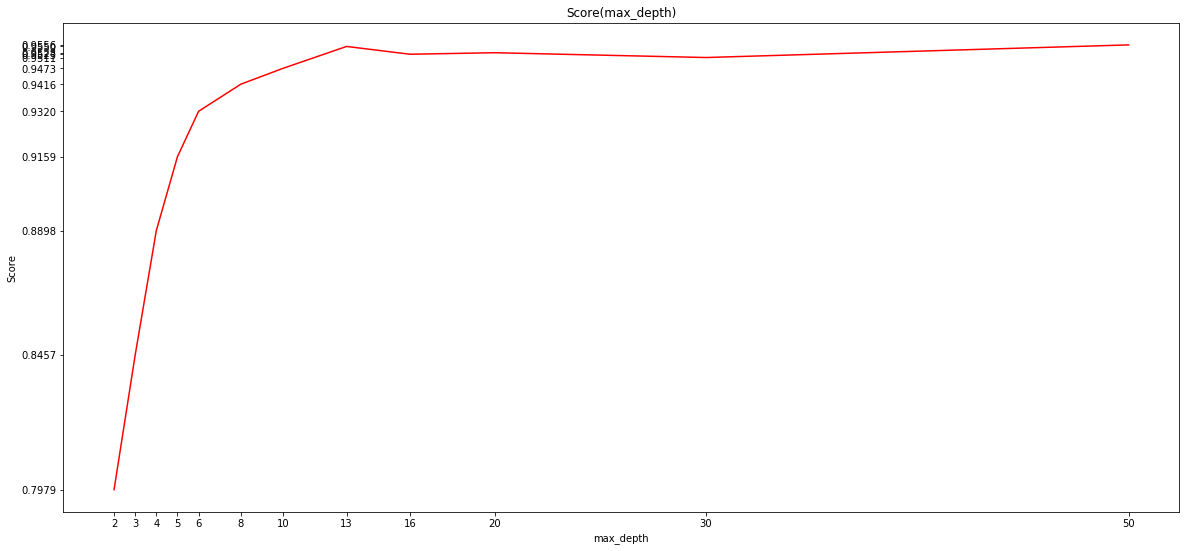

In [68]:
from matplotlib import pyplot as plt
import numpy as np
def visualisation(x, y):
    for k, v in x.items():
        plt.figure(figsize=(20, 9))
        plt.title('Score(%s)' % k)
        plt.xlabel(k)
        plt.ylabel('Score')
        plt.plot(v, y, 'r-')
        plt.xticks(v)
        plt.yticks(y)
        plt.show()
        

visualisation(n_trees, scores_trees)
visualisation(n_features, scores_features)
visualisation(n_depth, scores_depth)

Выберите верные утверждения:
1. Случайный лес сильно переобучается с ростом количества деревьев.
2. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев.
3. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
4. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
5. При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.
6. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.
7. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

1 + Деревья в лесу переобучаются => лес переобучен, но переобученность деревьев компенсируется их количеством в принятии решения
2 + Видно из графика 1
3 + Видно из графика 1
4 + Из графика 2 видна небольшая деградация модели при увеличении числа признаков в деревьях
5 - Видно из графика 2
6 - Видно из графика 3, но нужно учесть, что при таком размере выборки выбранная глубина мала - в листьях остается еще большое количество элементов, дерево недообучается
7 + т.к 6, но опять же зависит от числа элементов в выборке